# Churn Reasons - Initial Walkthrough

In [3]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
#from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [4]:
SF_USER = 'kang.huang3@wework.com'
SF_ACCOUNT = 'ai42698.us-east-1'
SF_AUTHENTICATOR = 'externalbrowser'

sf_conn = snowflake.connector.connect(user=SF_USER, account=SF_ACCOUNT, authenticator=SF_AUTHENTICATOR)

# Start by pulling data from Snowflake

In [6]:
#for each commitment ("active term ID"), there are 2 targets: 
# 1. does this commitment renew at all?
# 2. does this commitment renew in x months?

# then, merge on location and reservable data from feature store

# filter to only commitments that end before this month, so we know the result of those commitments
# as well as remove months after they have already re-committed


renew_reason_query = """
WITH 
first_month AS (
    SELECT rm.account_uuid, rm.location_uuid, min(month) AS first_month
    from central.cdm_feature_store.reservable_monthly rm
    left join central.cdm.reservables r on rm.reservable_uuid = r.uuid
    GROUP BY 1,2
),
notice as(
    select r.reservation_uuid, started_on, max(ended_on) as ended_on, max(t.amount) as months_ahead
    from fivetran.spaceman_public.terms t
    left join central.cdm.reservations r on t.termable_id = r.reservation_id
    where type =  'MoveOutNotice' and  termable_type = 'ReservationBase' 
          and canceled_at is null and _fivetran_deleted = False
    group by 1,2
),
reasons as(
  select s.id as response_id,
          s.account_uuid, s.location_uuid,
          case 
              when REASON_FOR_LEAVING like '%COVID - 19%' then 'COVID -19'
              when REASON_FOR_LEAVING like '%,%' then 'Other'
          else REASON_FOR_LEAVING end as churn_reason,
          case 
            when lower(POST_WEWORK_NEXT_LOCATION) like any ('%home%','%remote%','%wfh%','%house%','%casa%') then 'WFH'
            when reason_for_leaving = 'WeWork is too expensive' then 'Price'
            when REASON_FOR_LEAVING in ('Wanted to have own space','Haven’t used WeWork’s space enough') then reason_for_leaving
          else null end as churn_reason_fixed,
         SURVEY_RESPONDED_AT::date as response_date, date_trunc('month', SURVEY_RESPONDED_AT) as response_month
  from central.cdm_customers.survey_responses_move_out_nps s
  where location_uuid is not null
        and nvl(churn_reason, 'Other') <> 'Other' 
),
by_res_target as(
  SELECT distinct
    reasons.*, a.sales_account_uuid,  bom.reservation_uuid,
    bom.commitment_full_duration, bom.commitment_term_start_local, bom.commitment_term_end_local,	
    bom.occupancy,
     case 
        when n.months_ahead is not null then n.months_ahead
        when bom.occupancy < 25 and  bom.commitment_full_duration < 12  then 1
        when (bom.occupancy < 75 and  bom.commitment_full_duration < 12) or bom.commitment_full_duration < 24  then 2
        when (bom.occupancy < 25) or (bom.occupancy < 75 and  bom.commitment_full_duration < 24) or (bom.commitment_full_duration < 12)  then 3
        else 6
     end as  months_notice,
     dateadd('month', months_notice * -1, bom.commitment_term_end_local) as required_notice_date,
         --filter to where perf_month, which is the earliest of:
     date_trunc('month', least( 
        nvl(reservation_gave_notice_local,'2999-01-01'),                        --the month they gave notice to leave
        required_notice_date                                                    --the month they were/are required to give notice to leave
     )) as perf_month, 
     f.first_month
  FROM reasons
  inner join central.cdm.space_inventory_bom bom
            on bom.account_uuid = reasons.account_uuid and bom.location_uuid = reasons.location_uuid
            and bom.report_month between dateadd(month,-3,response_month) and response_month
  left join first_month f on bom.account_uuid = f.account_uuid and bom.location_uuid = f.location_uuid
  left join notice n on bom.reservation_uuid = n.reservation_uuid and bom.commitment_term_start_local between n.started_on and nvl(n.ended_on, '2100-01-01')
  left join central.cdm.accounts a on reasons.account_uuid = a.account_uuid
  where bom.commitment_full_duration > 1 and reservable_type = 'Office' and not(nvl(a.IS_WEWORK_INC_AFFILIATES,FALSE))       
),
target as(
  select
    response_id, account_uuid, sales_account_uuid, location_uuid,
    churn_reason, churn_reason_fixed, response_date, response_month, 
    l.market, l.sales_market, count(*) as reses,
    max(commitment_full_duration) as commitment_duration,
    sum(t.occupancy) as desks,
    min(perf_month) as perf_month,  min(perf_month) as report_month,
    min(first_month) as first_month,
    min(commitment_term_start_local) as commitment_term_start_local
  from by_res_target t
  left join central.cdm.locations l on t.location_uuid = l.uuid
  group by 1,2,3,4,5,6,7,8,9,10
),
nps as(
  select
    t.response_id,
    avg(likelihood_recommend) as nps_score
  from central.cdm_customers.survey_responses_relationship_nps nps
  left join central.cdm.accounts a on nps.account_uuid = a.account_uuid
  inner join target t on a.sales_account_uuid=t.sales_account_uuid
  --  and nps.location_uuid=t.location_uuid
    and nps.survey_responded_at between dateadd('month',-24,t.perf_month) and dateadd('month',-1,t.perf_month) 
    group by 1
),
account_data as(
  select month, sales_account_uuid,
        sum(active_reservation_count) as active_reservation_count,
        sum(occupancy) as account_desks
  from central.cdm_feature_store.account_location_monthly
  group by 1,2
),
commitment_avg as(
  select target.response_id,
      avg(alm.COMPLETED_TOUR_COUNT) as avg_tours_completed,
      avg(alm.cr_minutes_used * 1.0 / alm.occupancy) as avg_prop_cr_minutes_used, 
      avg(alm.guest_visits * 1.0 / alm.occupancy) as avg_prop_guest_visits, 
      avg(alm.keycard_swipes * 1.0 / alm.occupancy) as avg_prop_keycard_swipes, 
      avg(alm.total_credits_used * 1.0 / alm.occupancy) as avg_prop_credits_used,
      avg(alm.cr_minutes_used) as avg_cr_minutes_used, 
      avg(alm.guest_visits) as avg_guest_visits, 
      avg(alm.keycard_swipes) as avg_keycard_swipes, 
      avg(alm.total_credits_used) as avg_credits_used,
      avg(alm.tickets_created - alm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT) as avg_tickets_created,
      avg(alm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT) as avg_billing_tickets 
  from target
  left join central.cdm_feature_store.account_location_monthly alm 
          on alm.month < target.perf_month 
          and alm.month >= least(nvl(target.commitment_term_start_local, current_date), dateadd('month',-6, target.perf_month) )
          and target.location_uuid = alm.location_uuid and target.sales_account_uuid = alm.sales_account_uuid
  where occupancy > 0
  group by 1
),
term_financials as(
  with res_fin as(
    select brt.response_id, brt.reservation_uuid, count(*) as months, 
         median(alm.occupancy) as desks,
         sum(gross_price_usd) as total_res_gross_price,
         sum(net_paid_price_usd) as total_res_net_price,  
         total_res_gross_price * 1.0 / months as monthly_res_gross_price,
         total_res_net_price * 1.0 / months as monthly_res_net_price,
         monthly_res_gross_price * 1.0 / desks as monthly_res_gross_arpm,
         monthly_res_net_price * 1.0 / desks as monthly_res_net_arpm
    from by_res_target brt
    left join central.cdm_feature_store.reservable_monthly alm 
            on alm.month between date_trunc('month',brt.commitment_term_start_local) and brt.commitment_term_end_local
            and brt.reservation_uuid = alm.reservation_uuid
    where alm.occupancy > 0
    group by 1,2
  ) 
  select response_id, 
         sum(total_res_gross_price) as total_gross_price,
         sum(total_res_net_price) as total_net_price,  
         sum(monthly_res_gross_price) as monthly_gross_price,
         sum(monthly_res_net_price) as monthly_net_price,
         avg(monthly_res_gross_arpm) as monthly_gross_arpm,  --should be weighted average
         avg(monthly_res_net_arpm) as monthly_net_arpm, 
         1 -  (monthly_net_arpm * 1.0 / nullif(monthly_gross_arpm,0)) as total_discount_perc         
  from res_fin
  group by 1
)
select 
    target.*,
    lag_1.region,

    fin.total_gross_price, fin.total_net_price,
    fin.monthly_gross_price, fin.monthly_net_price,
    fin.monthly_gross_arpm, fin.monthly_net_arpm, 
    fin.total_discount_perc,
    --(rm.market_price_usd - fin.monthly_gross_price) as new_price_change,
    --(rm.market_price_usd - fin.monthly_gross_price) *  1.0 /rm.capacity as new_arpm_change,
    --(rm.market_price_usd - fin.monthly_net_price)/nullif(rm.market_price_usd,0) as new_discount,
    --fin.total_discount_perc - new_discount as discount_change,
    
    ad.active_reservation_count, ad.account_desks,
    
    lag_1.SCHEDULED_TOUR_COUNT, lag_1.TOUR_COMPLETED_PCT, lag_1.SAME_LOCATION_AS_OPPORTUNITY_TOUR_PCT,  
    lag_1.tenure_months, case when lag_1.global_access_occupancy > 0 then 1 else 0 end as has_global_access,  
    lag_1.is_enterprise_500,
    lag_1.time_in_months_since_2010, 
    datediff('month', '2010-01-01', commitment_term_start_local) as start_date_months_since_2010,
    
    nps.nps_score,
    
    nvl(amm.ROLLING_6M_TOUR_COUNT,0) as ROLLING_6M_TOUR_COUNT,
    nvl(amm.weighted_building_tours,0) as weighted_building_tours,

    -- covid variables
    lag_1.COUNTRY_COVID19_MTD_CONFIRMED_CASES_PER_CAPITA,
    lag_1.COUNTRY_COVID19_CONFIRMED_CASE_COUNT_CHANGE_PREV_MONTH_PER_CAPITA,
    lag_1.COUNTRY_COVID19_MTD_AVG_WORKPLACES_CHANGE_PCT,  
    lag_1.MARKET_COVID19_MTD_CONFIRMED_CASE_COUNT,
    lag_1.MARKET_COVID19_CONFIRMED_CASE_COUNT_CHANGE_PREV_MONTH,
    lag_1.MARKET_COVID19_MTD_AVG_WORKPLACES_CHANGE_PCT,  
    

    -- lag activity variables
    lag_1.cr_minutes_used as lag1_cr_minutes_used, 
    lag_1.guest_visits as lag1_guest_visits, 
    lag_1.keycard_swipes as lag1_keycard_swipes, 
    lag_1.cr_minutes_used * 1.0 / lag_1.occupancy as lag1_prop_cr_minutes_used, 
    lag_1.guest_visits * 1.0 / lag_1.occupancy as lag1_prop_guest_visits, 
    lag_1.keycard_swipes * 1.0 / lag_1.occupancy as lag1_prop_keycard_swipes, 
    lag_1.total_credits_used * 1.0 / lag_1.occupancy  as lag1_prop_credits_used,
    lag_1.tickets_created - lag_1.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as lag1_tickets_created,
    lag_1.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as lag1_billing_tickets,
        
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_cr_minutes_used  else lag_2.cr_minutes_used * 1.0 / lag_2.occupancy                             end as lag2_prop_cr_minutes_used, 
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_guest_visits     else lag_2.guest_visits * 1.0 / lag_2.occupancy                                end as lag2_prop_guest_visits, 
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_keycard_swipes   else lag_2.keycard_swipes * 1.0 / lag_2.occupancy                              end as lag2_prop_keycard_swipes, 
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_credits_used     else lag_2.total_credits_used * 1.0 / lag_2.occupancy                          end as lag2_prop_credits_used, 
    case when nvl(lag_2.occupancy,0) = 0 then lag1_tickets_created       else lag_2.tickets_created - lag_2.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT   end as lag2_tickets_created,
    case when nvl(lag_2.occupancy,0) = 0 then lag1_billing_tickets       else lag_2.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT                           end as lag2_billing_tickets,

    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_cr_minutes_used  else lag_3.cr_minutes_used * 1.0 / lag_3.occupancy                             end as lag3_prop_cr_minutes_used, 
    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_guest_visits     else lag_3.guest_visits * 1.0 / lag_3.occupancy                                end as lag3_prop_guest_visits, 
    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_keycard_swipes   else lag_3.keycard_swipes * 1.0 / lag_3.occupancy                              end as lag3_prop_keycard_swipes, 
    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_credits_used     else lag_3.total_credits_used * 1.0 / lag_3.occupancy                          end as lag3_prop_credits_used, 
    case when nvl(lag_3.occupancy,0) = 0 then lag2_tickets_created       else lag_3.tickets_created - lag_3.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT   end as lag3_tickets_created,
    case when nvl(lag_3.occupancy,0) = 0 then lag2_billing_tickets       else lag_3.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT                           end as lag3_billing_tickets,
    
    (lag1_prop_cr_minutes_used + lag2_prop_cr_minutes_used + lag3_prop_cr_minutes_used) * 1.0 / 3 as ma3_prop_cr_minutes_used, 
    (lag1_prop_guest_visits + lag2_prop_guest_visits + lag3_prop_guest_visits) * 1.0 / 3 as ma3_prop_guest_visits, 
    (lag1_prop_keycard_swipes + lag2_prop_keycard_swipes + lag3_prop_keycard_swipes) * 1.0 / 3 as ma3_prop_keycard_swipes, 
    (lag1_tickets_created + lag2_tickets_created + lag3_tickets_created) * 1.0 / 3 as ma3_tickets_created, 
    (lag1_billing_tickets + lag2_billing_tickets + lag3_billing_tickets) * 1.0 / 3 as ma3_billing_tickets, 
    
    fm.guest_visits * 1.0 / fm.occupancy as first_month_prop_guest_visits, 
    fm.keycard_swipes * 1.0 / fm.occupancy as first_month_prop_keycard_swipes, 
    fm.tickets_created - fm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as first_month_tickets_created,
    fm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as first_month_billing_tickets,
    lag_1.MOVE_IN_MONTH_SALES_INTERACTION, lag_1.MOVE_IN_MONTH_KEYCARD_SWIPES, lag_1.MOVE_IN_MONTH_CR_CREDITS_USED,
    
    avg_tours_completed, avg_prop_cr_minutes_used, 
    avg_prop_guest_visits, avg_prop_keycard_swipes, 
    avg_tickets_created, avg_billing_tickets,
    avg_prop_credits_used,
    avg_cr_minutes_used, avg_guest_visits,
    avg_keycard_swipes, avg_credits_used,
    
    lm.location_age, 
    lm.mtd_discount_pct as location_discount_percent, lm.mtd_non_hd_desk_occupancy_rate as location_occupancy_rate,
    lm.mtd_financial_occupancy as location_financial_occupancy,
    lm.ticket_count - lm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as location_tickets_created,
    lm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as location_billing_tickets,
    lm.tour_completed * 1.0 / lm.MTD_DESK_CAPACITY as last_month_building_tours,
    lm.keycard_swipes * 1.0 / nvl(lm.MTD_DESK_OCCUPANCY, lm.MTD_DESK_CAPACITY) as location_keycard_swipes,
    
    --
    pf_loc.desk_count as loc_deskcnt, 
    pf_loc.room_count as loc_roomcnt, 
    pf_loc.desk_occupancy as loc_deskocc, 
    pf_loc.room_occupancy as loc_roomocc, 
    pf_loc.financial_occupancy as loc_focc,
    pf_loc.market_price_per_desk as loc_marketppd, 
    pf_loc.net_paid_price_per_desk as loc_netppd, 
    pf_loc.discount as loc_discount, 
    pf_loc.enterprise_mix as loc_entmix,
    --
    pf_mkt.market_age, 
    pf_mkt.desk_occupancy as mkt_deskocc, 
    pf_mkt.room_occupancy as mkt_roomocc, 
    pf_mkt.financial_occupancy as mkt_focc,
    pf_mkt.market_price_per_desk as mkt_marketppd, 
    pf_mkt.net_paid_price_per_desk as mkt_netppd, 
    pf_mkt.discount as mkt_discount, 
    pf_mkt.enterprise_mix as mkt_entmix   
        
 --   lm.DESK_LOSS_LAST_3_MONTHS  * 1.0 / nvl(lm.MTD_DESK_OCCUPANCY, lm.MTD_DESK_CAPACITY)  as location_desk_loss,
 --   lm.DESK_SALES_LAST_3_MONTHS * 1.0 / lm.MTD_DESK_CAPACITY as location_desk_sales,
 --  lm.mtd_desk_churn_notice_count * 1.0 / lm.MTD_DESK_OCCUPANCY as location_churn_notice
from target
left join term_financials fin 
        on target.response_id = fin.response_id
left join central.cdm_feature_store.account_location_monthly lag_1 
        on target.report_month = dateadd('month',1,lag_1.month) and target.location_uuid = lag_1.location_uuid
            and target.sales_account_uuid = lag_1.sales_account_uuid
left join central.cdm_feature_store.account_location_monthly lag_2 
        on target.report_month = dateadd('month',2,lag_2.month) and target.location_uuid = lag_2.location_uuid
            and target.sales_account_uuid = lag_2.sales_account_uuid
left join central.cdm_feature_store.account_location_monthly lag_3 
        on target.report_month = dateadd('month',3,lag_3.month) and target.location_uuid = lag_3.location_uuid
            and target.sales_account_uuid = lag_3.sales_account_uuid        
left join central.cdm_feature_store.location_monthly lm 
        on target.report_month = dateadd('month',1,lm.month) and target.location_uuid = lm.location_uuid
left join account_data ad  
        on target.report_month = dateadd('month',1,ad.month) and target.sales_account_uuid = ad.sales_account_uuid
left join commitment_avg as ca
        on target.response_id = ca.response_id
left join central.cdm_feature_store.account_location_monthly fm
            on target.first_month = fm.month and target.location_uuid = fm.location_uuid
            and target.sales_account_uuid = fm.sales_account_uuid
left join central.cdm_feature_store.account_market_monthly amm
            on target.report_month = dateadd('month',1,amm.month) and target.sales_market = amm.sales_market
                and target.sales_account_uuid = amm.sales_account_uuid
left join revops.revops_dw.fact_location_monthly_metrics pf_loc
      on pf_loc.location_uuid=target.location_uuid and pf_loc.month=target.report_month
left join revops.revops_dw.fact_market_monthly_metrics pf_mkt
      on pf_mkt.market=target.market and pf_mkt.month=target.report_month
left join nps on target.response_id = nps.response_id
where lag_1.occupancy > 0 
        and fm.occupancy > 0
        order by response_id, report_month
"""




In [12]:
renew_query = '''
WITH
target_init AS (
  SELECT ex.primary_reservation_uuid, ex.active_term_id,
            max(case when ex.is_extended then 1 else 0 end) as within_term,
            min(case when ex.is_extended then ex.report_month else date_trunc('month', ex.active_term_end_date) end) AS extension_month
  FROM central.cdm_sales.reservation_extension_rates ex
  left join  central.cdm_sales.reservation_extension_rates next_3
              on ex.primary_reservation_uuid = next_3.primary_reservation_uuid
                  and next_3.report_month between dateadd('month',1,ex.report_month) and dateadd('month',3, ex.report_month)
                  and ex.report_month = date_trunc('month', ex.active_term_end_date)
                  and ((next_3.extension_subtype in ('Commitment-to-Commitment','M2M-to-Commitment'))
                                       or next_3.active_term_id is not null)
  WHERE (ex.extension_subtype = ('Commitment-to-Commitment') or next_3.report_month is not null)
    and ex.active_term_id is not null
  GROUP BY 1,2
),
notice as(
    select r.reservation_uuid, started_on, max(ended_on) as ended_on, max(t.amount) as months_ahead
    from fivetran.spaceman_public.terms t
    left join central.cdm.reservations r on t.termable_id = r.reservation_id
    where type =  'MoveOutNotice' and  termable_type = 'ReservationBase'
          and canceled_at is null and _fivetran_deleted = False
    group by 1,2
),
first_month AS (
  with rv1 as(
    SELECT reservation_uuid, reservable_uuid, 
           reservation_started_on_utc as first_date, reservation_ended_on_utc as last_date,
           min(report_month) AS first_month,
           min(reservable_open_date_local) as open_date
    from central.cdm.space_inventory_bom
    where reservation_uuid is not null
    GROUP BY 1,2,3,4
  )
  select reservation_uuid, reservable_uuid,
         first_month, 
         lag(last_date) over(partition by reservable_uuid order by last_date)::date as prev_last_date,
         datediff('day', nvl(prev_last_date, open_date), first_date)-1 as vacant_days
  from rv1
),
reservables as(
select reservable_uuid, floor_name, count(distinct commitment_term_start_local) as commitments, max(reservable_archived_at_local) as archived_at_local
from central.cdm.space_inventory_bom
group by 1,2
),
target as(
  SELECT
    ex.report_month, extract(year from ex.report_month) as report_year,
    ex.primary_reservation_uuid, ex.primary_reservation_reservable_uuid, ex.location_uuid, ex.sales_account_uuid,
    s.SALESFORCE_OPPORTUNITY_ID,
    rv.floor_name,
         ex.active_commitment_full_duration, ex.active_commitment_remaining_duration,
         ex.active_term_start_date, ex.active_term_end_date,
         ex.starting_occupancy as starting_desks,
         ex.active_usd,
         ex.active_term_id is not null AS is_on_commitment, -- can just filter on this if we only want to predict renewals
         t.extension_month is not null as is_extended,
         datediff('month',ex.report_month,t.extension_month) AS months_to_extension,
         t.extension_month, ex.active_term_id, within_term,
         case
            when n.months_ahead is not null then n.months_ahead
            when ex.starting_occupancy < 25 and  ex.active_commitment_full_duration < 12  then 1
            when (ex.starting_occupancy < 75 and  ex.active_commitment_full_duration < 12) or ex.active_commitment_full_duration < 24  then 2
            when (ex.starting_occupancy < 25) or (ex.starting_occupancy < 75 and  ex.active_commitment_full_duration < 24) or (ex.active_commitment_full_duration < 12)  then 3
            else 6
         end as  months_notice,
         dateadd('month',months_notice * -1, ex.active_term_end_date) as required_notice_date,
         --filter to where perf_month, which is the earliest of:
         date_trunc('month', least(
            case when within_term = 1 then t.extension_month else '2999-01-01' end, --the month they signed to renew
            nvl(reservation_gave_notice_local,'2999-01-01'),                        --the month they gave notice to leave
            required_notice_date,                                                   --the month they were/are required to give notice to leave
            date_trunc('month', current_date)
         )) as perf_month,
         f.first_month, l.market, l.sales_market, l.region,
         case when perf_month < date_trunc('month',current_date) then 1 else 0 end as training_data,
         nvl(f.vacant_days,0) as vacant_days
  FROM central.cdm_sales.reservation_extension_rates ex
  left join central.cdm_sales.sales_records s on ex.PRIMARY_RESERVATION_UUID = s.PRIMARY_RESERVATION_UUID
  left join target_init t on t.primary_reservation_uuid = ex.primary_reservation_uuid and t.active_term_id = ex.active_term_id
              --note - this may not work for mtm -> commitment since merging on active term id
  left join central.cdm.reservations r on ex.primary_reservation_uuid = r.reservation_uuid
  left join first_month f on ex.primary_reservation_uuid = f.reservation_uuid
  left join reservables rv on ex.PRIMARY_RESERVATION_RESERVABLE_UUID = rv.reservable_uuid
  left join central.cdm.locations l on ex.location_uuid = l.uuid
  left join notice n on ex.primary_reservation_uuid = n.reservation_uuid and ex.active_term_start_date between n.started_on and nvl(n.ended_on, '2100-01-01')
  where
        is_on_commitment
        and ex.report_month = perf_month
        and rv.archived_at_local is null
        and rv.commitments > 1
  qualify row_number() over(partition by s.PRIMARY_RESERVATION_UUID order by s.sales_record_date desc)=1
),
nps as(
  select
    t.primary_reservation_uuid, t.active_term_id,
    avg(likelihood_recommend) as nps_score
  from central.cdm_customers.survey_responses_relationship_nps nps
  left join central.cdm.accounts a on nps.account_uuid = a.account_uuid
  inner join target t on a.sales_account_uuid=t.sales_account_uuid
  --  and nps.location_uuid=t.location_uuid
    and nps.survey_responded_at between dateadd('month',-12,t.perf_month) and dateadd('month',-1,t.perf_month)
    group by 1,2
),
nps_accmkt as (
  select sales_account_uuid, sales_market,
        sum(likelihood_recommend*recency)/nullif(sum(recency),0) as nps_score_accmkt
    from(
        select
            t.sales_account_uuid, t.sales_market, t.primary_reservation_uuid,
            12.0-datediff('month',nps.survey_responded_at,t.required_notice_date) as recency,
            likelihood_recommend
            from "CENTRAL"."CDM_CUSTOMERS"."SURVEY_RESPONSES_RELATIONSHIP_NPS" nps
            left join central.cdm.accounts a
                on nps.account_uuid = a.account_uuid
            inner join target t
                on t.sales_account_uuid=a.sales_account_uuid
            where datediff('month',nps.survey_responded_at,t.required_notice_date)<=12
        )
    group by 1,2
),
account_data as(
  select month, sales_account_uuid,
        sum(active_reservation_count) as active_reservation_count,
        sum(occupancy) as account_desks
  from central.cdm_feature_store.account_location_monthly
  group by 1,2
),
prev_renewals as(
  with temp as(
    select t.report_month, t.sales_account_uuid,
          sum(t2.is_extended::numeric) as prev_renewals,
          sum(case when t2.is_extended = false then 1 else 0 end) as prev_commitment_ends
   from target t
   inner join target t2 on t.report_month > t2.report_month --making sure you knew the outcome before the month of prediction
                            and t.sales_account_uuid = t2.sales_account_uuid
   group by 1,2
  ) select distinct report_month, sales_account_uuid, prev_renewals, prev_commitment_ends from temp
),
commitment_avg as(
  select target.report_month, target.sales_account_uuid, target.location_uuid,
      sum(alm.global_access_occupancy) as global_access_count_6m,
      sum(alm.COMPLETED_TOUR_COUNT) as tours_completed_6m,
      sum(alm.cr_minutes_used * 1.0 / alm.occupancy) as prop_cr_minutes_used_6m,
      sum(alm.guest_visits * 1.0 / alm.occupancy) as prop_guest_visits_6m,
      sum(alm.keycard_swipes * 1.0 / alm.occupancy) as prop_keycard_swipes_6m,
      sum(alm.total_credits_used * 1.0 / alm.occupancy) as prop_credits_used_6m,
      sum(alm.cr_minutes_used) as cr_minutes_used_6m,
      sum(alm.guest_visits) as guest_visits_6m,
      sum(alm.keycard_swipes) as keycard_swipes_6m,
      sum(alm.total_credits_used) as credits_used_6m,
      sum(alm.tickets_created - alm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT) as tickets_created_6m,
      sum(alm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT) as billing_tickets_6m,
      sum(alm.HVAC_TICKET_COUNT) as hvac_tickets_6m
  from target
  left join central.cdm_feature_store.account_location_monthly alm
          on alm.month < target.report_month
          and alm.month >= least(nvl(target.active_term_start_date, current_date), dateadd('month',-6, report_month) )
          and target.location_uuid = alm.location_uuid and target.sales_account_uuid = alm.sales_account_uuid
  where occupancy > 0
  group by 1,2,3
),
term_financials as(
  select target.primary_reservation_uuid, target.active_term_id, count(*) as months, median(occupancy) as desks,
         sum(gross_price_usd) as total_gross_price,
         sum(net_paid_price_usd) as total_net_price,
         total_gross_price * 1.0 / months as monthly_gross_price,
         total_net_price * 1.0 / months as monthly_net_price,
         monthly_gross_price * 1.0 / desks as monthly_gross_arpm,
         monthly_net_price * 1.0 / desks as monthly_net_arpm,
         1 -  (monthly_net_arpm * 1.0 / nullif(monthly_gross_arpm,0)) as total_discount_perc
  from target
  left join central.cdm_feature_store.reservable_monthly alm
          on alm.month between target.active_term_start_date and target.active_term_end_date
          and target.primary_reservation_uuid = alm.reservation_uuid
  where occupancy > 0
  group by 1,2
)
select target.*,
    rm.reservable_type,
    rm.capacity,
--    case when rm.internal_room_count > 1 then 1 else 0 end as internal_rooms,
    rm.internal_room_count,
    rm.usf_per_desk,
    rm.age_in_days,
    rm.is_wwlo,
    rm.square_footage ,
    rm.has_window,

    fin.total_gross_price, fin.total_net_price,
    fin.monthly_gross_price, fin.monthly_net_price,
    fin.monthly_gross_arpm, fin.monthly_net_arpm,
    fin.total_discount_perc,
    (rm.market_price_usd - fin.monthly_gross_price) as new_price_change,
    (rm.market_price_usd - fin.monthly_gross_price) *  1.0 /rm.capacity as new_arpm_change,
    (rm.market_price_usd - fin.monthly_net_price)/nullif(rm.market_price_usd,0) as new_discount,
    fin.total_discount_perc - new_discount as discount_change,

    ad.active_reservation_count,
    ad.account_desks,

    lag_1.DESK_LOSS_LAST_3_MONTHS,
    lag_1.DESK_SALES_LAST_3_MONTHS,
    lag_1.RENEWED_DESKS_LAST_3_MONTHS,
    lag_1.M2M_OCCUPANCY_MIX,
    lag_1.CBP_OCCUPANCY_MIX,
    lag_1.LOCATION_TOUR_CREATED as Account_LOCATION_TOUR_CREATED,
    lag_1.LOCATION_TOUR_COMPLETED as Account_LOCATION_TOUR_COMPLETED,
    lag_1.LOCATION_OPPORTUNITY_CLOSED_WON as Account_LOCATION_OPPORTUNITY_CLOSED_WON,

    lag_1.tenure_months,
--    case when lag_1.global_access_occupancy > 0 then 1 else 0 end as has_global_access,
    lag_1.is_enterprise_500,
    lag_1.time_in_months_since_2010,
    datediff('month', '2010-01-01', active_term_start_date) as start_date_months_since_2010,

    coalesce(nps.nps_score, nps_accmkt.nps_score_accmkt) as nps_score,

    nvl(amm.ROLLING_6M_TOUR_COUNT,0) as ROLLING_6M_TOUR_COUNT,
    nvl(amm.weighted_building_tours,0) as weighted_building_tours,

    -- covid variables
    lag_1.MARKET_COVID19_CONFIRMED_CASE_COUNT_CHANGE_PREV_MONTH,
    lag_1.MARKET_COVID19_MTD_ACTIVE_CASE_COUNT,
    lag_1.MARKET_COVID19_ACTIVE_CASE_COUNT_CHANGE_PREV_MONTH,
    lag_1.MARKET_COVID19_MTD_AVG_WORKPLACES_CHANGE_PCT,
    lag_1.COUNTRY_COVID19_MTD_CONFIRMED_CASES_PER_CAPITA,
    lag_1.COUNTRY_COVID19_CONFIRMED_CASE_COUNT_CHANGE_PREV_MONTH_PER_CAPITA,
    lag_1.COUNTRY_COVID19_MTD_AVG_WORKPLACES_CHANGE_PCT,

    -- lag activity variables
    lag_1.cr_minutes_used as lag1_cr_minutes_used,
    lag_1.cr_credits_used as lag1_cr_credits_used,
    lag_1.guest_visits as lag1_guest_visits,
    lag_1.keycard_swipes as lag1_keycard_swipes,
    lag_1.cr_minutes_used * 1.0 / lag_1.occupancy as lag1_prop_cr_minutes_used,
    lag_1.guest_visits * 1.0 / lag_1.occupancy as lag1_prop_guest_visits,
    lag_1.keycard_swipes * 1.0 / lag_1.occupancy as lag1_prop_keycard_swipes,
    lag_1.total_credits_used * 1.0 / lag_1.occupancy  as lag1_prop_credits_used,
    lag_1.tickets_created - lag_1.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as lag1_tickets_created,
    lag_1.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as lag1_billing_tickets,
    lag_1.HVAC_TICKET_COUNT as lag1_hvac_tickets,
    lag_1.KEYCARD_SWIPES_CHANGE_FROM_PREV_3M,
    lag_1.KEYCARD_SWIPES_CHANGE_FROM_PREV_MONTH,
    lag_1.TICKETS_CREATED_CHANGE_FROM_PREV_3M,
    lag_1.INVOICED_REVENUE-lag_2.INVOICED_REVENUE as invoiced_revenue_change_prev_month,

    -- IS THIS CHEATING
    nvl(max(is_extended) over (partition by target.primary_reservation_uuid order by target.report_month rows between unbounded preceding and 1 preceding), FALSE) as renewed_before,

    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_cr_minutes_used  else lag_2.cr_minutes_used * 1.0 / lag_2.occupancy                             end as lag2_prop_cr_minutes_used,
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_guest_visits     else lag_2.guest_visits * 1.0 / lag_2.occupancy                                end as lag2_prop_guest_visits,
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_keycard_swipes   else lag_2.keycard_swipes * 1.0 / lag_2.occupancy                              end as lag2_prop_keycard_swipes,
    case when nvl(lag_2.occupancy,0) = 0 then lag1_prop_credits_used     else lag_2.total_credits_used * 1.0 / lag_2.occupancy                          end as lag2_prop_credits_used,
    case when nvl(lag_2.occupancy,0) = 0 then lag1_tickets_created       else lag_2.tickets_created - lag_2.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT   end as lag2_tickets_created,
    case when nvl(lag_2.occupancy,0) = 0 then lag1_billing_tickets       else lag_2.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT                           end as lag2_billing_tickets,

    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_cr_minutes_used  else lag_3.cr_minutes_used * 1.0 / lag_3.occupancy                             end as lag3_prop_cr_minutes_used,
    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_guest_visits     else lag_3.guest_visits * 1.0 / lag_3.occupancy                                end as lag3_prop_guest_visits,
    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_keycard_swipes   else lag_3.keycard_swipes * 1.0 / lag_3.occupancy                              end as lag3_prop_keycard_swipes,
    case when nvl(lag_3.occupancy,0) = 0 then lag2_prop_credits_used     else lag_3.total_credits_used * 1.0 / lag_3.occupancy                          end as lag3_prop_credits_used,
    case when nvl(lag_3.occupancy,0) = 0 then lag2_tickets_created       else lag_3.tickets_created - lag_3.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT   end as lag3_tickets_created,
    case when nvl(lag_3.occupancy,0) = 0 then lag2_billing_tickets       else lag_3.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT                           end as lag3_billing_tickets,

    (lag1_prop_cr_minutes_used + lag2_prop_cr_minutes_used + lag3_prop_cr_minutes_used) * 1.0 / 3 as ma3_prop_cr_minutes_used,
    (lag1_prop_guest_visits + lag2_prop_guest_visits + lag3_prop_guest_visits) * 1.0 / 3 as ma3_prop_guest_visits,
    (lag1_prop_keycard_swipes + lag2_prop_keycard_swipes + lag3_prop_keycard_swipes) * 1.0 / 3 as ma3_prop_keycard_swipes,
    (lag1_tickets_created + lag2_tickets_created + lag3_tickets_created) * 1.0 / 3 as ma3_tickets_created,
    (lag1_billing_tickets + lag2_billing_tickets + lag3_billing_tickets) * 1.0 / 3 as ma3_billing_tickets,

    fm.guest_visits * 1.0 / fm.occupancy as first_month_prop_guest_visits,
    fm.keycard_swipes * 1.0 / fm.occupancy as first_month_prop_keycard_swipes,
    fm.tickets_created - fm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as first_month_tickets_created,
    fm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as first_month_billing_tickets,

    lag_1.MOVE_IN_MONTH_SALES_INTERACTION,
    lag_1.MOVE_IN_MONTH_KEYCARD_SWIPES,
    lag_1.MOVE_IN_MONTH_CR_CREDITS_USED,

    global_access_count_6m,
    tours_completed_6m,
    prop_cr_minutes_used_6m,
    prop_guest_visits_6m,
    prop_keycard_swipes_6m,
    tickets_created_6m,
    billing_tickets_6m,
    hvac_tickets_6m,
    prop_credits_used_6m,
    cr_minutes_used_6m,
    guest_visits_6m,
    keycard_swipes_6m,
    credits_used_6m,

    lm.ticket_count - lm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as location_tickets_created,
    lm.BILLING_PAYMENTS_AND_ADD_ONS_TICKET_COUNT as location_billing_tickets,
    lm.tour_completed as location_tour_completed,
    lm.keycard_swipes as location_keycard_swipes,
--    lm.tour_completed * 1.0 / lm.MTD_DESK_CAPACITY as last_month_building_tours,
--    lm.keycard_swipes * 1.0 / nvl(lm.MTD_DESK_OCCUPANCY, lm.MTD_DESK_CAPACITY) as location_keycard_swipes,
    --
    pf_sku.DESK_OCCUPIED as sku_deskcnt,
    pf_sku.ROOM_OCCUPIED as sku_roomcnt,
    pf_sku.desk_occupancy as sku_deskocc,
    pf_sku.room_occupancy as sku_roomocc,
    pf_sku.financial_occupancy as sku_focc,
    pf_sku.market_price_per_desk as sku_marketppd,
    pf_sku.net_paid_price_per_desk as sku_netppd,
    pf_sku.discount as sku_discount,
    pf_sku.enterprise_mix as sku_entmix,
    --
    pf_loc.location_age,
    pf_loc.DESK_OCCUPIED as loc_deskcnt,
    pf_loc.ROOM_OCCUPIED as loc_roomcnt,
    pf_loc.desk_occupancy as loc_deskocc,
    pf_loc.room_occupancy as loc_roomocc,
    pf_loc.financial_occupancy as loc_focc,
    pf_loc.market_price_per_desk as loc_marketppd,
    pf_loc.net_paid_price_per_desk as loc_netppd,
    pf_loc.discount as loc_discount,
    pf_loc.enterprise_mix as loc_entmix,
    --
    pf_loc1.DESK_OCCUPIED as loc1_deskcnt,
    pf_loc1.desk_occupancy as loc1_deskocc,
    pf_loc1.financial_occupancy as loc1_focc,
    pf_loc1.net_paid_price_per_desk as loc1_netppd,
    pf_loc1.discount as loc1_discount,
    pf_loc1.enterprise_mix as loc1_entmix,
    --
    pf_mkt.market_age,
    pf_mkt.desk_occupancy as mkt_deskocc,
    pf_mkt.room_occupancy as mkt_roomocc,
    pf_mkt.financial_occupancy as mkt_focc,
    pf_mkt.market_price_per_desk as mkt_marketppd,
    pf_mkt.net_paid_price_per_desk as mkt_netppd,
    pf_mkt.discount as mkt_discount,
    pf_mkt.enterprise_mix as mkt_entmix,
    --
    pf_reg.desk_occupancy as reg_deskocc,
    pf_reg.room_occupancy as reg_roomocc,
    pf_reg.financial_occupancy as reg_focc,
    pf_reg.market_price_per_desk as reg_marketppd,
    pf_reg.net_paid_price_per_desk as reg_netppd,
    pf_reg.discount as reg_discount,
    pf_reg.enterprise_mix as reg_entmix,
    --
    nvl(pr.prev_renewals,0) as prev_renewals_count, nvl(pr.prev_commitment_ends,0) as prev_commitment_ends_count,
    pr.prev_renewals * 1.0 / nullif((pr.prev_renewals + pr.prev_commitment_ends),0) as prev_renewal_rate,

    lm.DESK_LOSS_LAST_3_MONTHS  * 1.0 / nvl(lm.MTD_DESK_OCCUPANCY, lm.MTD_DESK_CAPACITY)  as location_desk_loss,
    lm.DESK_SALES_LAST_3_MONTHS * 1.0 / lm.MTD_DESK_CAPACITY as location_desk_sales,
    lm.mtd_desk_churn_notice_count * 1.0 / lm.MTD_DESK_OCCUPANCY as location_churn_notice
from target
left join central.cdm_feature_store.reservable_monthly rm
        on target.report_month = dateadd('month',1,rm.month) and target.primary_reservation_reservable_uuid = rm.reservable_uuid
left join term_financials fin
        on target.primary_reservation_uuid = fin.primary_reservation_uuid and target.active_term_id = fin.active_term_id
left join central.cdm_feature_store.account_location_monthly lag_1
        on target.report_month = dateadd('month',1,lag_1.month) and target.location_uuid = lag_1.location_uuid
            and target.sales_account_uuid = lag_1.sales_account_uuid
left join central.cdm_feature_store.account_location_monthly lag_2
        on target.report_month = dateadd('month',2,lag_2.month) and target.location_uuid = lag_2.location_uuid
            and target.sales_account_uuid = lag_2.sales_account_uuid
left join central.cdm_feature_store.account_location_monthly lag_3
        on target.report_month = dateadd('month',3,lag_3.month) and target.location_uuid = lag_3.location_uuid
            and target.sales_account_uuid = lag_3.sales_account_uuid
left join central.cdm_feature_store.location_monthly lm
        on target.report_month = dateadd('month',1,lm.month) and target.location_uuid = lm.location_uuid
left join account_data ad
        on target.report_month = dateadd('month',1,ad.month) and target.sales_account_uuid = ad.sales_account_uuid
left join prev_renewals pr
        on target.report_month = pr.report_month and target.sales_account_uuid = pr.sales_account_uuid
left join commitment_avg as ca
        on target.report_month = ca.report_month and target.location_uuid = ca.location_uuid
            and target.sales_account_uuid = ca.sales_account_uuid
left join central.cdm_feature_store.account_location_monthly fm
            on target.first_month = fm.month and target.location_uuid = fm.location_uuid
            and target.sales_account_uuid = fm.sales_account_uuid
left join central.cdm_feature_store.reservable_monthly fmr
            on dateadd('month',-1,target.first_month) = fmr.month and target.primary_reservation_reservable_uuid = fmr.reservable_uuid
left join central.cdm_feature_store.account_market_monthly amm
            on target.report_month = dateadd('month',1,amm.month) and target.sales_market = amm.sales_market
                and target.sales_account_uuid = amm.sales_account_uuid
left join revops.revops_dw.fact_sku_monthly_metrics pf_sku
      on pf_sku.location_uuid=target.location_uuid and pf_sku.sku=rm.sku and pf_sku.month=target.report_month
left join revops.revops_dw.fact_location_monthly_metrics pf_loc
      on pf_loc.location_uuid=target.location_uuid and pf_loc.month=target.report_month
left join revops.revops_dw.fact_market_monthly_metrics pf_mkt
      on pf_mkt.market=target.market and pf_mkt.month=target.report_month
left join revops.revops_dw.fact_region_monthly_metrics pf_reg
      on pf_reg.region=target.region and pf_reg.month=target.report_month
left join revops.revops_dw.fact_location_monthly_metrics pf_loc1
        on target.report_month = dateadd('month',1,pf_loc1.month) and target.location_uuid = pf_loc1.location_uuid
left join nps on target.primary_reservation_uuid = nps.primary_reservation_uuid and target.active_term_id = nps.active_term_id
left join nps_accmkt on target.sales_account_uuid = nps_accmkt.sales_account_uuid and target.sales_market = nps_accmkt.sales_market
where lag_1.occupancy > 0 --remove first commitment month since no data
        and rm.reservable_type = 'Office' and not(nvl(rm.IS_WEWORK_INC_AFFILIATES,FALSE))
        and fm.occupancy > 0
        order by primary_reservation_uuid, report_month
'''

In [14]:
def sf_to_pd(query = '', clean_col_names=False):
    if query == '':
        return
   
    curs = sf_conn.cursor()
    data = curs.execute(query).fetchall()
    if clean_col_names:
        columns = [clean_name(col[0]) for col in curs.description]
    else:
        columns = [col[0] for col in curs.description]
    df = pd.DataFrame(data=data, columns=columns)

    return df

data_raw = sf_to_pd(renew_query)

In [16]:
data_raw.to_csv('2021-September.csv')

In [4]:
# PULL UPDATED CHURN REASONS FROM TOPIC MODEL
data = pd.read_csv('../data/churn_raw.csv')

covid_reasons = pd.read_csv('../data/covid_reason.csv')
covid_reasons["response_id"] = covid_reasons.id_move_out
covid_reasons["covid_reason"] = covid_reasons.new_reason
covid_reasons = covid_reasons[['response_id','covid_reason']]
covid_reasons  = covid_reasons.groupby(["response_id"]).min()

topic_reasons = pd.read_csv('../data/renew_reason_20210302.csv')
topic_reasons.columns = [col.lower() for col in topic_reasons.columns]
topic_reasons["response_id"] = topic_reasons.id
topic_reasons = topic_reasons[['response_id','new_reason']]
topic_reasons  = topic_reasons.groupby(["response_id"]).min()


data.response_id = pd.to_numeric(data.response_id)
data = data.merge(covid_reasons, how = 'left', on = ['response_id'])
data = data.merge(topic_reasons, how = 'left', on = ['response_id'])
data["new_reason_expanded"] = data.new_reason.combine_first(data.churn_reason_fixed)
data = data.drop(columns=['churn_reason_fixed'])

#print(data[data.churn_reason == 'COVID -19'].covid_reason.value_counts(dropna = False))
print(data.new_reason_expanded.value_counts(dropna = False))


NaN                                   12280
WFH                                    2067
Wanted to have own space               1736
Price                                  1244
Haven’t used WeWork’s space enough      581
Service                                 169
Downsize/Business problems               77
Name: new_reason_expanded, dtype: int64


# Initial Investigation




[Text(0, 0, 'COVID -19'),
 Text(0, 0, "Don't need office space anymore"),
 Text(0, 0, 'Wanted to have own space'),
 Text(0, 0, 'WeWork is too expensive'),
 Text(0, 0, 'Haven’t used WeWork’s space enough'),
 Text(0, 0, 'I am not satisfied with WeWork'),
 Text(0, 0, 'Right office size or membership type wasn’t available'),
 Text(0, 0, 'I needed space in a location where there is not currently a WeWork')]

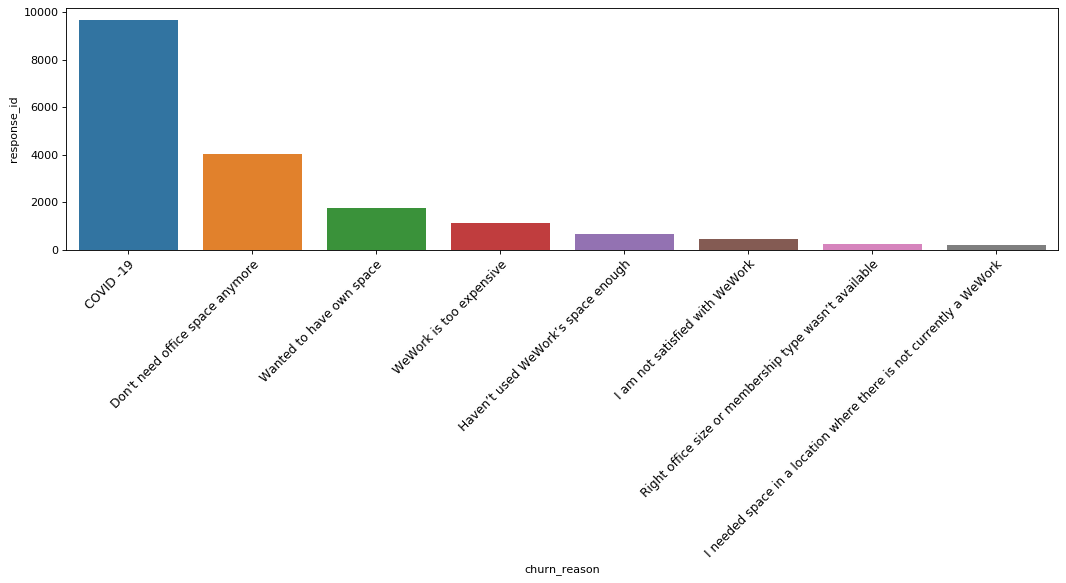

In [6]:
chart_data = data[['churn_reason','response_id']].groupby('churn_reason').count().sort_values("response_id",  ascending = False)
chart_data["churn_reason"]  = chart_data.index
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
chart = sns.barplot(data=chart_data, x="churn_reason", y="response_id")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size = 11)



# Establish Baseline


In [8]:
def log_transform(transform_data):
    search_terms = ['arpm', 'price', '_count','used', 'guest', 'ticket', 'minute','keycard', 'months' \
                    'capacity','desk','usf','per_capita']
    log_features = transform_data.columns[transform_data.columns.str.contains('|'.join(search_terms))].to_list()
    log_features = log_features + ['location_age']
#    print(log_features)
    for col in log_features:
        #print(col)
        transform_data[col] = transform_data[col].apply(lambda x: np.log(x) if x>=1 else -np.log(1-x)) 

    return transform_data

def get_results(y, y_test, prediction, verbose=True):
    accuracy = prediction == y_test
    accuracy = sum(accuracy) / len(accuracy)
    weight_f1_score = f1_score(y_test, prediction, average = 'weighted')
   
    if verbose:
        labels = y.unique()
        f1_scores = f1_score(y_test, prediction, average = None, labels = labels)
        prediction_values =  pd.Series(prediction).value_counts(normalize  = True)
        actual_values = pd.Series(y_test).value_counts(normalize  = True)

        summary_data  =  pd.DataFrame(f1_scores, index =  labels, columns =   ['F1 Score']) \
                            .join(prediction_values.rename("Prediction Proportions")) \
                            .join(actual_values.rename("Actual Test Proportions"))
        display(summary_data)
        print("Accuracy: ", accuracy)
        print("Avg. F1 Score: ", weight_f1_score)
    return accuracy, weight_f1_score
    
def evaluate_confident_prediction(model, X_test, y, y_test, prediction, confidence, verbose=True):
    probs = model.predict_proba(X_test)
    probs = np.max(probs, axis=1)
    inds = np.where(probs>confidence)[0]
    coverage = len(inds) / len(probs) 
    y_test = y_test.to_numpy()
    if verbose:
        print ('coverage: ', coverage)
    accuracy, f1_score = get_results(y, y_test[inds], prediction[inds], verbose)
    return coverage, f1_score

In [44]:
y_test.to_numpy(), prediction

(array(['COVID -19', 'COVID -19', 'COVID -19', ...,
        "Don't need office space anymore", 'COVID -19',
        'WeWork is too expensive'], dtype=object),
 array(['COVID -19', 'COVID -19', 'COVID -19', ...,
        "Don't need office space anymore", 'COVID -19',
        "Don't need office space anymore"], dtype=object))

In [9]:
# Set up data for model
targets = ['churn_reason','covid_reason','new_reason_expanded','new_reason']

drop_columns = ['response_id', 'sales_account_uuid', 'location_uuid',
                'response_date', 'response_month', 'account_uuid',
                'market', 'sales_market','first_month','region',
                'perf_month','commitment_term_start_local', 'report_month', 
               ]

regions = ['Europe, Middle East & Africa', 'US & Canada', 'Latin America']

clean_data = data.copy()
clean_data = clean_data[clean_data.region.isin(regions)].reset_index(drop = True)

clean_data = clean_data.join(pd.get_dummies(clean_data["region"]))
clean_data = clean_data.join(pd.get_dummies(clean_data["market"]))

data_store = clean_data.copy()

clean_data = clean_data.drop(columns = drop_columns).reset_index(drop = True) \
                .fillna(0) \
                .apply(pd.to_numeric, errors='ignore', downcast='float')

clean_data = log_transform(clean_data)


print("DONE")

DONE


In [106]:
#  PLAIN XGBOOST
target = 'churn_reason'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy().drop(columns = target_drop).reset_index(drop =  True)

X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model = XGBClassifier(objective="multi:softmax")
model.fit(X_train, y_train)
prediction = model.predict(X_test)

get_results(y, y_test, prediction)

#62.9, 57.9

Train Obs:  9964 Test Obs:  3322


/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.222222,0.007526,0.030403
COVID -19,0.753092,0.787176,0.575858
Don't need office space anymore,0.371859,0.139976,0.219446
WeWork is too expensive,0.226891,0.017459,0.054184
Wanted to have own space,0.349835,0.028296,0.062914
Haven’t used WeWork’s space enough,0.197802,0.014449,0.040337
Right office size or membership type wasn’t available,0.322581,0.003010,0.006321
I needed space in a location where there is not currently a WeWork,0.095238,0.002107,0.010536


Accuracy:  0.6158940397350994
Avg. F1 Score:  0.5673580654133424


(0.6158940397350994, 0.5673580654133424)

In [107]:
evaluate_confident_prediction(model, X_test, y, y_test, prediction, 0.9)

coverage:  0.16736905478627334


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.454545,0.010791,0.028777
COVID -19,0.889145,0.850719,0.706835
Don't need office space anymore,0.461538,0.052158,0.134892
WeWork is too expensive,0.500000,0.014388,0.035971
Wanted to have own space,0.791667,0.041367,0.044964
Haven’t used WeWork’s space enough,0.421053,0.007194,0.026978
Right office size or membership type wasn’t available,0.666667,0.016187,0.010791
I needed space in a location where there is not currently a WeWork,0.400000,0.007194,0.010791


Accuracy:  0.8111510791366906
Avg. F1 Score:  0.7802693312356672


(0.16736905478627334, 0.7802693312356672)

In [30]:
#  XGBOOST WITH SMOTE

target = 'churn_reason'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy().drop(columns = target_drop).reset_index(drop =  True)

X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

oversample = SMOTE()
y_train_pre  =  y_train.copy()
X_train, y_train = oversample.fit_resample(X_train, y_train)


print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model2 = XGBClassifier(objective="multi:softmax")
model2.fit(X_train, y_train)
prediction = model2.predict(X_test)

get_results(y, y_test, prediction)


Train Obs:  45904 Test Obs:  3322
Accuracy:  0.5900060204695966
Avg. F1 Score:  0.5537052358324736


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.214286,0.011740,0.030403
COVID -19,0.731316,0.737207,0.575858
Don't need office space anymore,0.369447,0.166767,0.219446
WeWork is too expensive,0.251852,0.027092,0.054184
Wanted to have own space,0.339394,0.036424,0.062914
Haven’t used WeWork’s space enough,0.176796,0.014148,0.040337
Right office size or membership type wasn’t available,0.303030,0.003612,0.006321
I needed space in a location where there is not currently a WeWork,0.088889,0.003010,0.010536


coverage:  0.36484045755568933
Accuracy:  0.7211221122112211
Avg. F1 Score:  0.6881039070217798


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.392157,0.014026,0.028053
COVID -19,0.826879,0.807756,0.641089
Don't need office space anymore,0.445087,0.099010,0.186469
WeWork is too expensive,0.452381,0.022277,0.047030
Wanted to have own space,0.547170,0.034653,0.052805
Haven’t used WeWork’s space enough,0.250000,0.011551,0.028053
Right office size or membership type wasn’t available,0.500000,0.007426,0.009076
I needed space in a location where there is not currently a WeWork,0.307692,0.003300,0.007426


In [34]:
evaluate_confident_prediction(model2, X_test, y, y_test, prediction, 0.9)

coverage:  0.14960866947621915
Accuracy:  0.772635814889336
Avg. F1 Score:  0.7487462577500871


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.461538,0.022133,0.030181
COVID -19,0.867978,0.776660,0.655936
Don't need office space anymore,0.537313,0.098592,0.171026
WeWork is too expensive,0.451613,0.020121,0.042254
Wanted to have own space,0.711111,0.046278,0.044266
Haven’t used WeWork’s space enough,0.363636,0.012072,0.032193
Right office size or membership type wasn’t available,0.625000,0.018109,0.014085
I needed space in a location where there is not currently a WeWork,0.250000,0.006036,0.010060


In [31]:
#  XGBOOST WITH SAMPLE WEIGHTS
target = 'churn_reason'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy().drop(columns = target_drop).reset_index(drop =  True)

X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

sample_weight = compute_sample_weight('balanced', y_train)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model3 = XGBClassifier(objective="multi:softmax")
model3.fit(X_train, y_train, sample_weight = sample_weight)
prediction = model3.predict(X_test)

get_results(y, y_test, prediction)
evaluate_confident_prediction(model3, X_test, y, y_test, prediction, 0.5)

Train Obs:  9964 Test Obs:  3322
Accuracy:  0.5629139072847682
Avg. F1 Score:  0.5501435509885629


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.232258,0.016255,0.030403
COVID -19,0.709434,0.620710,0.575858
Don't need office space anymore,0.406210,0.245936,0.219446
WeWork is too expensive,0.273973,0.033715,0.054184
Wanted to have own space,0.325333,0.049970,0.062914
Haven’t used WeWork’s space enough,0.176991,0.027694,0.040337
Right office size or membership type wasn’t available,0.312500,0.003311,0.006321
I needed space in a location where there is not currently a WeWork,0.093023,0.002408,0.010536


coverage:  0.7338952438290187
Accuracy:  0.6197703035274815
Avg. F1 Score:  0.6060192294016602


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.333333,0.015997,0.028302
COVID -19,0.754316,0.647662,0.587777
Don't need office space anymore,0.444444,0.228466,0.214520
WeWork is too expensive,0.336538,0.030763,0.054553
Wanted to have own space,0.428016,0.045529,0.059885
Haven’t used WeWork’s space enough,0.258065,0.024200,0.039377
Right office size or membership type wasn’t available,0.357143,0.004512,0.006973
I needed space in a location where there is not currently a WeWork,0.142857,0.002871,0.008614


In [24]:
#  COVID BINARY
target = 'churn_reason'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy().drop(columns = target_drop).reset_index(drop =  True)

model_data[target] =  (model_data[target] == 'COVID -19')

X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scale_pos_weight_actual = (~y_train).sum() / y_train.sum()

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model4 = XGBClassifier(scale_pos_weight = scale_pos_weight_actual)
model4.fit(X_train, y_train)
prediction = model4.predict(X_test)

get_results(y, y_test, prediction)

evaluate_confident_prediction(model4, X_test, y, y_test, prediction, 0.5)

model = LogisticRegression(max_iter = 5000, class_weight = 'balanced', solver='liblinear')   
model.fit(X_train, y_train)
prediction = model.predict(X_test)
get_results(y, y_test, prediction)
evaluate_confident_prediction(model, X_test, y, y_test, prediction, 0.5)

Train Obs:  9964 Test Obs:  3322
Accuracy:  0.6553281155930163
Avg. F1 Score:  0.6549043193669759


,F1 Score,Prediction Proportions,Actual Test Proportions
False,0.590047,0.416616,0.424142
True,0.702675,0.583384,0.575858


coverage:  1.0
Accuracy:  0.6553281155930163
Avg. F1 Score:  0.6549043193669759


,F1 Score,Prediction Proportions,Actual Test Proportions
False,0.590047,0.416616,0.424142
True,0.702675,0.583384,0.575858


Accuracy:  0.590307043949428
Avg. F1 Score:  0.5921442142212708


,F1 Score,Prediction Proportions,Actual Test Proportions
False,0.538488,0.463576,0.424142
True,0.631664,0.536424,0.575858


coverage:  1.0
Accuracy:  0.590307043949428
Avg. F1 Score:  0.5921442142212708


,F1 Score,Prediction Proportions,Actual Test Proportions
False,0.538488,0.463576,0.424142
True,0.631664,0.536424,0.575858


In [25]:
#  predicting the 4 covid topics
target = 'covid_reason'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy()[clean_data.covid_reason!=0].drop(columns=target_drop).reset_index(drop =  True)
#model_data = model_data[model_data.new_reason != 'covid - other']
X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

sample_weight = compute_sample_weight('balanced', y_train)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model5 = XGBClassifier(objective="multi:softmax")
model5.fit(X_train, y_train)
prediction = model5.predict(X_test)

get_results(y, y_test, prediction)
evaluate_confident_prediction(model5, X_test, y, y_test, prediction, 0.5)
#try on all 11 cats

Train Obs:  1338 Test Obs:  446
Accuracy:  0.273542600896861
Avg. F1 Score:  0.25813240720281155


,F1 Score,Prediction Proportions,Actual Test Proportions
covid - satisfy,0.095890,0.134529,0.192825
covid - service,0.294416,0.204036,0.237668
covid - other,0.397759,0.466368,0.334081
covid - price,0.156250,0.195067,0.235426


coverage:  0.7331838565022422
Accuracy:  0.26299694189602446
Avg. F1 Score:  0.2424430758888964


,F1 Score,Prediction Proportions,Actual Test Proportions
covid - satisfy,0.096154,0.128440,0.189602
covid - service,0.273973,0.195719,0.250765
covid - other,0.383764,0.507645,0.321101
covid - price,0.135338,0.168196,0.238532


In [26]:
#  predicting all, with the 4 covid topics
target = 'churn_reason'
target_drop = [x for x in targets if x!=target]


model_data  =  clean_data.copy().reset_index(drop =  True)
model_data = model_data[(model_data.covid_reason != 0) | \
                        (model_data.churn_reason != 'COVID -19')]
model_data.loc[model_data.churn_reason == 'COVID -19', 'churn_reason'] = model_data[model_data.churn_reason == 'COVID -19'].covid_reason
model_data = model_data.drop(columns=target_drop).reset_index(drop =  True)

X = model_data.loc[:, model_data.columns != 'churn_reason']
y = model_data['churn_reason']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

sample_weight = compute_sample_weight('balanced', y_train)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model5 = XGBClassifier(objective="multi:softmax")
model5.fit(X_train, y_train)
prediction = model5.predict(X_test)

get_results(y, y_test, prediction)
evaluate_confident_prediction(model5, X_test, y, y_test, prediction, 0.5)

Train Obs:  5564 Test Obs:  1855
Accuracy:  0.4129380053908356
Avg. F1 Score:  0.34619132952975135


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.273381,0.020485,0.054447
covid - satisfy,0.000000,0.005391,0.046361
Don't need office space anymore,0.585415,0.686253,0.392992
WeWork is too expensive,0.340299,0.083558,0.097035
Wanted to have own space,0.335878,0.099191,0.112668
Haven’t used WeWork’s space enough,0.164835,0.025876,0.072237
Right office size or membership type wasn’t available,0.296296,0.003235,0.011321
I needed space in a location where there is not currently a WeWork,0.046512,0.004313,0.018868
covid - service,0.124138,0.021024,0.057143
covid - other,0.038278,0.032345,0.080323


coverage:  0.7099730458221024
Accuracy:  0.4905087319665907
Avg. F1 Score:  0.41585730919507585


,F1 Score,Prediction Proportions,Actual Test Proportions
I am not satisfied with WeWork,0.346939,0.021260,0.053151
covid - satisfy,0.000000,0.001519,0.038724
Don't need office space anymore,0.641221,0.754746,0.438876
WeWork is too expensive,0.411483,0.067578,0.091116
Wanted to have own space,0.425856,0.087320,0.112377
Haven’t used WeWork’s space enough,0.213115,0.021260,0.071374
Right office size or membership type wasn’t available,0.363636,0.004556,0.012149
I needed space in a location where there is not currently a WeWork,0.066667,0.003797,0.018983
covid - service,0.105263,0.012908,0.044799
covid - other,0.018018,0.015186,0.069096


In [27]:
#  predicting the new!! topics
target = 'new_reason'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy()[clean_data.new_reason!=0].drop(columns=target_drop).reset_index(drop =  True)
#model_data = model_data[model_data.new_reason != 'covid - other']
X = model_data.loc[:, model_data.columns != 'new_reason']
y = model_data['new_reason']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model = XGBClassifier(objective="multi:softmax")
model.fit(X_train, y_train)
prediction = model.predict(X_test)

get_results(y, y_test, prediction)
evaluate_confident_prediction(model, X_test, y, y_test, prediction, 0.5)

Train Obs:  804 Test Obs:  268
Accuracy:  0.3208955223880597
Avg. F1 Score:  0.2920149428234388


,F1 Score,Prediction Proportions,Actual Test Proportions
Haven’t used WeWork’s space enough,0.066667,0.033582,0.078358
Price,0.386364,0.369403,0.287313
Wanted to have own space,0.294118,0.115672,0.138060
Service,0.074074,0.063433,0.138060
Downsize/Business problems,0.000000,0.011194,0.052239
WFH,0.408377,0.406716,0.305970


coverage:  0.7686567164179104
Accuracy:  0.33495145631067963
Avg. F1 Score:  0.3016339442072691


,F1 Score,Prediction Proportions,Actual Test Proportions
Haven’t used WeWork’s space enough,0.000000,0.014563,0.063107
Price,0.376812,0.373786,0.296117
Wanted to have own space,0.339623,0.111650,0.145631
Service,0.095238,0.058252,0.145631
Downsize/Business problems,0.000000,0.004854,0.048544
WFH,0.421053,0.436893,0.300971


In [10]:
#  predicting the new!! topics, expanded to include all WFH + all "haven't used enough" and "wanted own space"
target = 'new_reason_expanded'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy()[clean_data[target]!=0].drop(columns=target_drop).reset_index(drop =  True)
X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model = XGBClassifier(objective="multi:softmax")
model.fit(X_train, y_train)
prediction = model.predict(X_test)

get_results(y, y_test, prediction)
evaluate_confident_prediction(model, X_test, y, y_test, prediction, 0.5)

Train Obs:  3090 Test Obs:  1030
[15:54:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,F1 Score,Prediction Proportions,Actual Test Proportions
Price,0.397790,0.150485,0.200971
Wanted to have own space,0.545932,0.172816,0.197087
Haven’t used WeWork’s space enough,0.239521,0.048544,0.113592
Service,0.000000,0.001942,0.035922
Downsize/Business problems,0.000000,0.000971,0.013592
WFH,0.662409,0.625243,0.438835


Accuracy:  0.5427184466019418
Avg. F1 Score:  0.5054363103281431
coverage:  0.8640776699029126


,F1 Score,Prediction Proportions,Actual Test Proportions
Price,0.417508,0.139326,0.194382
Wanted to have own space,0.582822,0.171910,0.194382
Haven’t used WeWork’s space enough,0.246377,0.042697,0.112360
Service,0.000000,0.002247,0.040449
Downsize/Business problems,0.000000,NaN,0.015730
WFH,0.690796,0.643820,0.442697


Accuracy:  0.5707865168539326
Avg. F1 Score:  0.5279422375760922


(0.8640776699029126, 0.5279422375760922)

In [11]:
#  predicting the new!! topics, expanded to include all WFH + all "haven't used enough" and "wanted own space"
target = 'new_reason_expanded'
target_drop = [x for x in targets if x!=target]

model_data  =  clean_data.copy()[clean_data[target]!=0].drop(columns=target_drop).reset_index(drop =  True)
X = model_data.loc[:, model_data.columns != target]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
sample_weight = compute_sample_weight('balanced', y_train)

print("Train Obs: ",len(y_train), "Test Obs: ",len(y_test))

model = XGBClassifier(objective="multi:softprob", 
                      max_depth=6, 
                      colsample_bytree=0.8, 
                      subsample=0.9, 
                      learning_rate=0.1,
                      n_estimators=500,
                      min_child_weight=3,
                      gamma=0,
                      reg_alpha=1e-5,
                     )
model.fit(X_train, y_train, sample_weight=sample_weight)
prediction = model.predict(X_test)

get_results(y, y_test, prediction)


Train Obs:  3090 Test Obs:  1030
[15:54:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,F1 Score,Prediction Proportions,Actual Test Proportions
Price,0.424552,0.178641,0.200971
Wanted to have own space,0.548223,0.185437,0.197087
Haven’t used WeWork’s space enough,0.254902,0.084466,0.113592
Service,0.000000,0.007767,0.035922
Downsize/Business problems,0.000000,0.001942,0.013592
WFH,0.659406,0.541748,0.438835


Accuracy:  0.5339805825242718
Avg. F1 Score:  0.5116958326242513


(0.5339805825242718, 0.5116958326242513)

In [128]:
evaluate_confident_prediction(model, X_test, y, y_test, prediction, 0.9)

coverage:  0.25339805825242717


,F1 Score,Prediction Proportions,Actual Test Proportions
Price,0.689655,0.164751,0.168582
Wanted to have own space,0.877698,0.268199,0.264368
Haven’t used WeWork’s space enough,0.604651,0.072797,0.091954
Service,0.000000,0.007663,0.026820
Downsize/Business problems,0.000000,NaN,0.007663
WFH,0.818182,0.486590,0.440613


Accuracy:  0.7777777777777778
Avg. F1 Score:  0.7644004431541357


(0.25339805825242717, 0.7644004431541357)

Text(0, 0.5, 'f1 score')

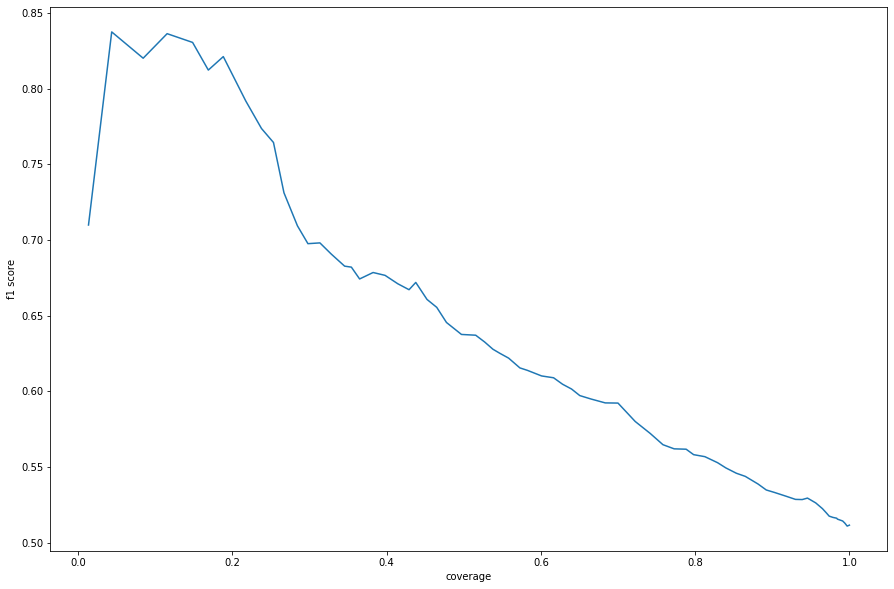

In [125]:
# metrics = []
# for thresh in np.arange(0, 1, 0.01):
#     metrics.append(evaluate_confident_prediction(model, X_test, y, y_test, prediction, thresh, verbose=False))
plt.figure(figsize=(15,10))
plt.plot(*zip(*metrics))
plt.xlabel('coverage')
plt.ylabel('f1 score')

### Tune max_depth and min_child_weight

In [75]:
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", 
                      colsample_bytree=0.8, 
                      subsample=0.8, 
                      learning_rate=0.3,
                      n_estimators=100,
                     ), param_grid=param_test1, n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train, sample_weight=sample_weight)

/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

In [76]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 7, 'min_child_weight': 3}, 0.517799352750809)

In [78]:
param_test2 = {
    'max_depth': [6, 7, 8],
    'min_child_weight': [2, 3, 4]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", 
                      colsample_bytree=0.8, 
                      subsample=0.8, 
                      learning_rate=0.3,
                      n_estimators=100,
                     ), param_grid=param_test2, n_jobs=4, cv=5)
gsearch2.fit(X_train, y_train, sample_weight=sample_weight)

/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

In [79]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 6, 'min_child_weight': 2}, 0.5216828478964401)

### Tune gamma

In [80]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0, 5)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", 
                      colsample_bytree=0.8, 
                      subsample=0.8, 
                      learning_rate=0.3,
                      n_estimators=100,
                      max_depth=6, 
                      min_child_weight=2,                  
                     ), param_grid=param_test3, n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train, sample_weight=sample_weight)

/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:23:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=6, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
             

In [81]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.5216828478964401)

### Tune subsample and colsample_bytree

In [82]:
param_test4 = {
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)]
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", 
                      colsample_bytree=0.8, 
                      subsample=0.8, 
                      learning_rate=0.3,
                      n_estimators=100,
                      max_depth=6, 
                      min_child_weight=,  
                      gamma=0,
                     ), param_grid=param_test4, n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train, sample_weight=sample_weight)

/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:28:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=6, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                

In [83]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.5236245954692557)

### Tuning Regularization Parameters

In [84]:
param_test5 = {
    'reg_alpha': [1e-5, 1e-2, 0.1,1,100], #[0, 1e-5, 1e-4, 1e-3], #
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", 
                      colsample_bytree=0.9, 
                      subsample=0.8, 
                      learning_rate=0.3,
                      n_estimators=100,
                      max_depth=6, 
                      min_child_weight=2,  
                      gamma=0,
                     ), param_grid=param_test5, n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train, sample_weight=sample_weight)

/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=6, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                

In [85]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 0.5242718446601942)

### Reducing Learning Rate and Add More Trees

In [87]:
param_test6 = {
    'learning_rate': [1e-3, 1e-2, 0.1, 0.3, 0.5],
    'n_estimators': [50, 100, 500, 1000]
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(objective="multi:softprob", 
                      colsample_bytree=0.9, 
                      subsample=0.8, 
                      learning_rate=0.3,
                      n_estimators=100,
                      max_depth=6, 
                      min_child_weight=2,  
                      gamma=0,
                      reg_alpha=1e-05,
                     ), param_grid=param_test6, n_jobs=4, cv=5)
gsearch6.fit(X_train, y_train, sample_weight=sample_weight)

/Users/kanghuang/anaconda3/envs/test/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=6, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=1e-05,
                                     reg_lambda=None, scale_pos_weight=None,
               

In [88]:
gsearch6.best_params_, gsearch6.best_score_

({'learning_rate': 0.1, 'n_estimators': 500}, 0.5313915857605178)

# Which features are most important?

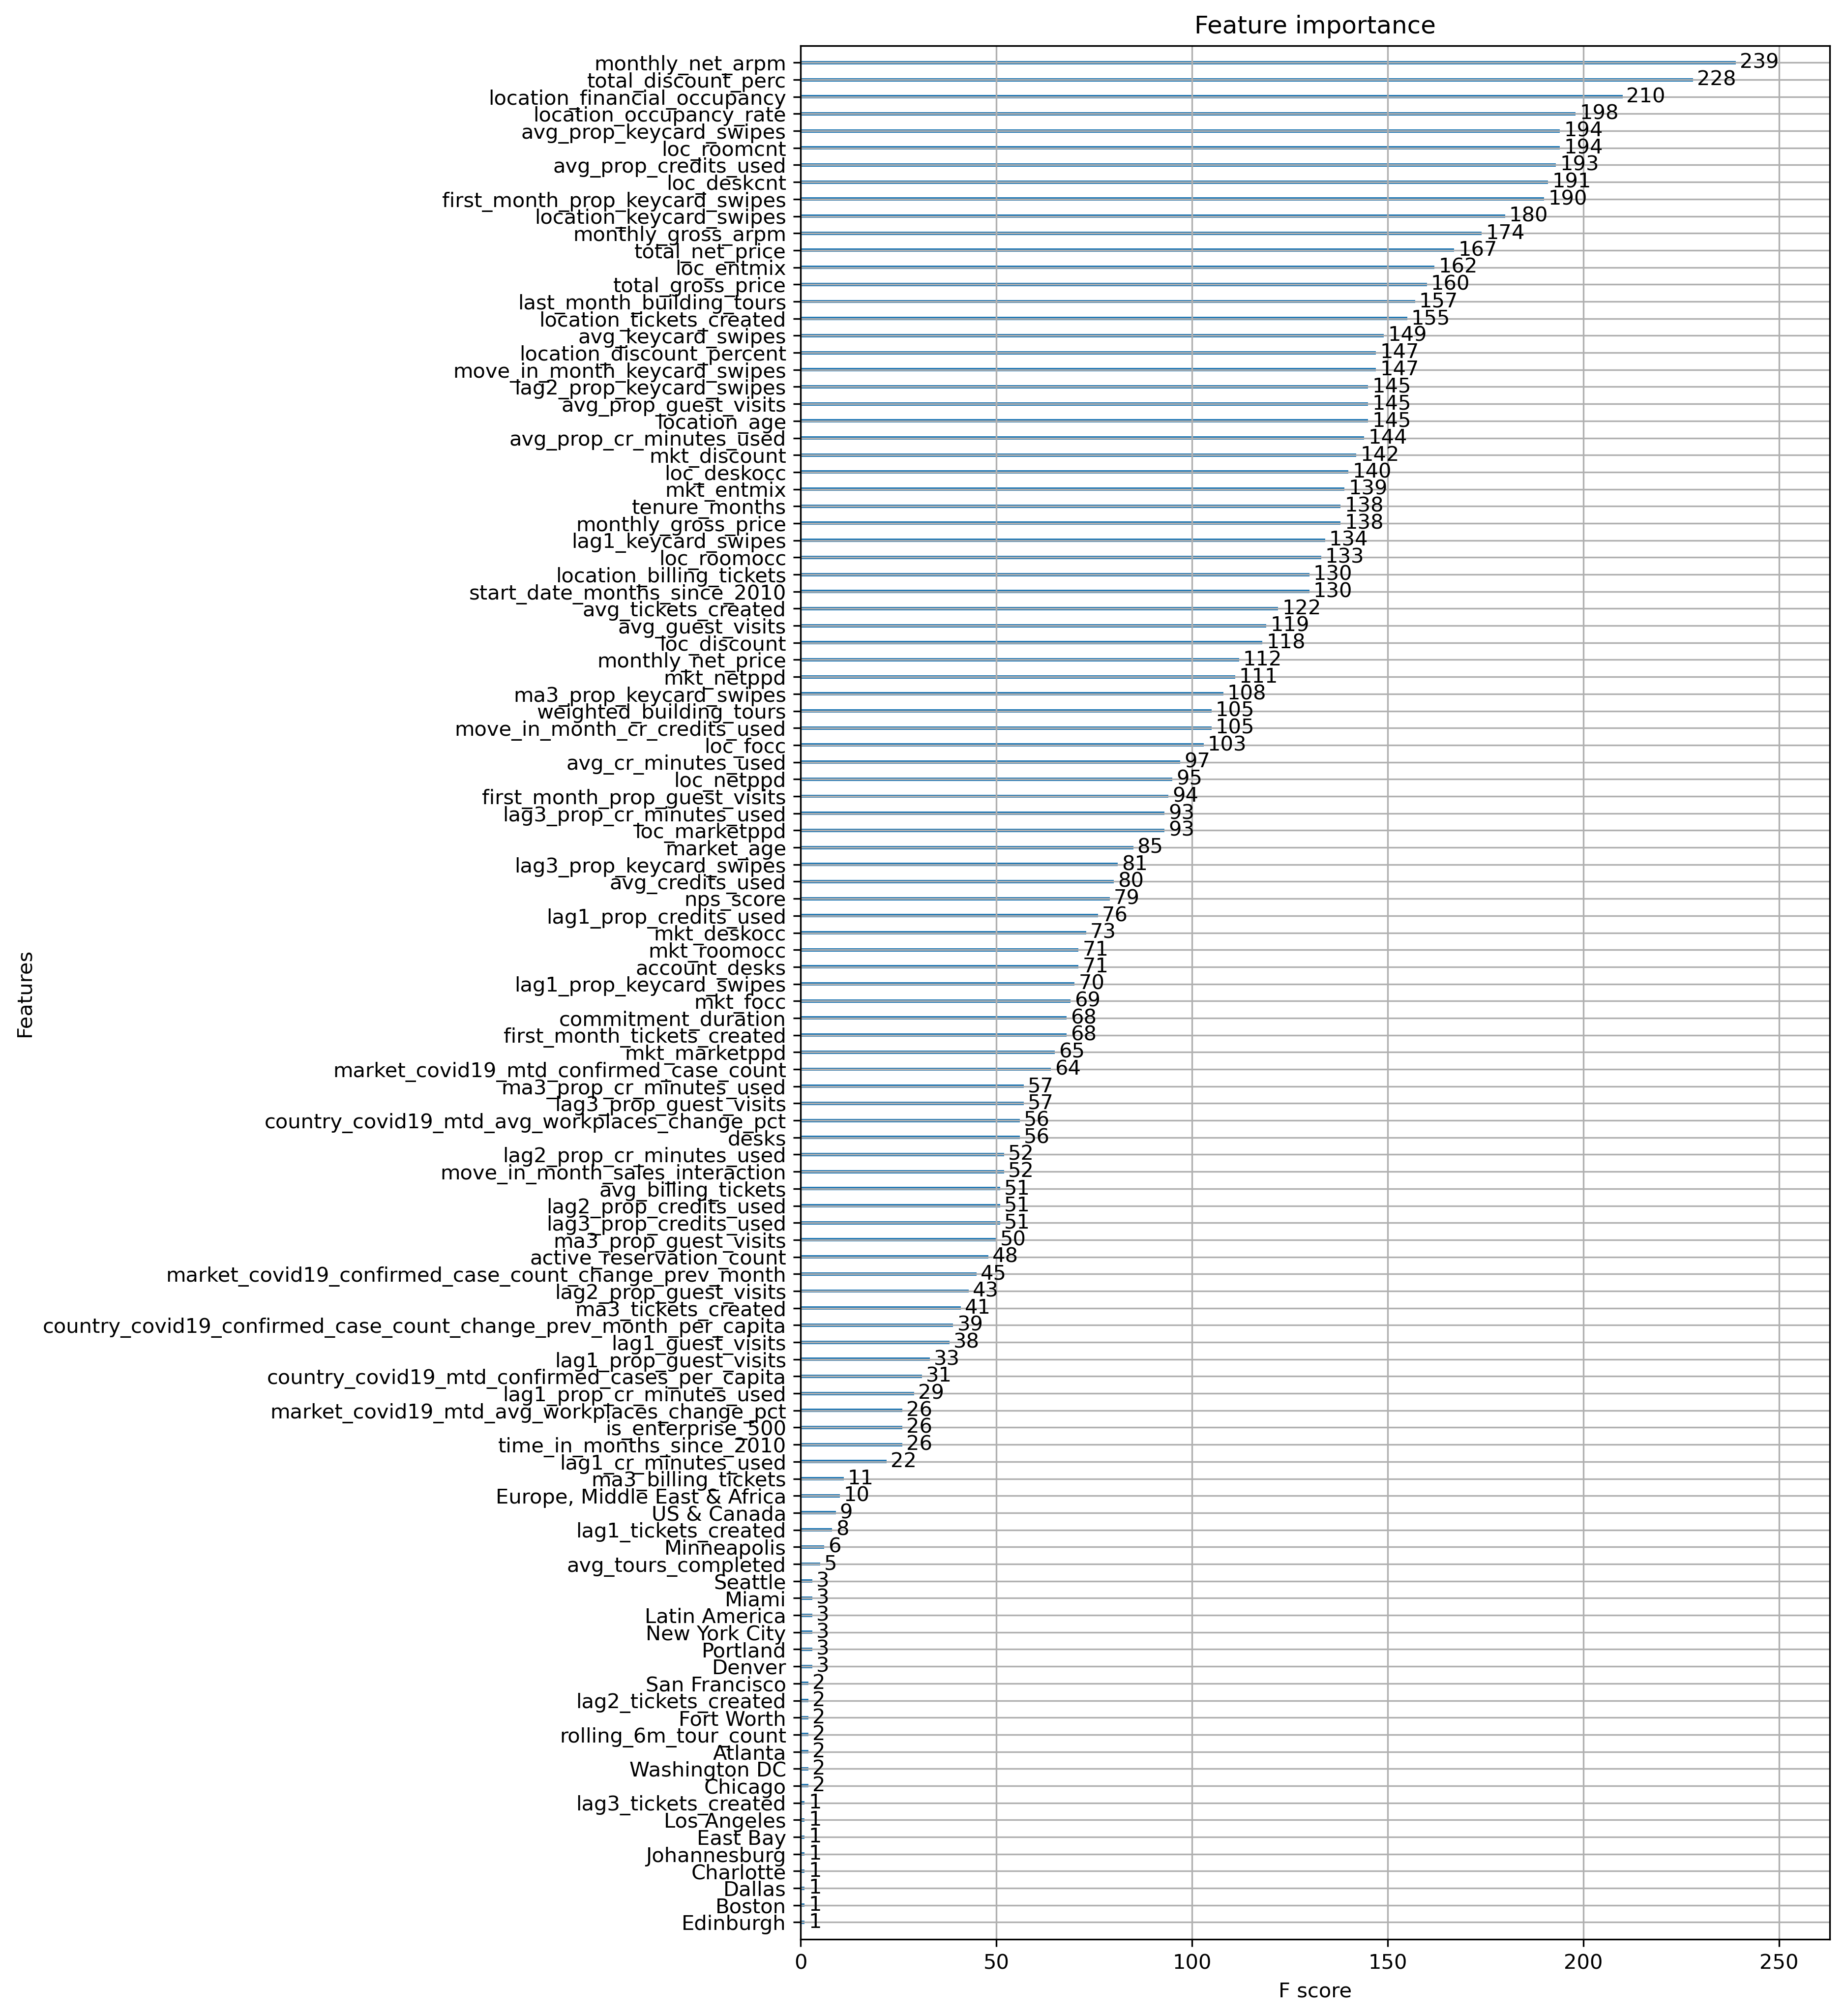

In [36]:
fig, ax = plt.subplots(figsize=(9,17), dpi= 300)
plot_importance(model, ax=ax)#, max_num_features=50)

#ax.figure.tight_layout()
#ax.figure.savefig('feature_importance.png')


# Testing

In [5]:
chart_data

,response_id,churn_reason
churn_reason,,
COVID -19,9538,COVID -19
Don't need office space anymore,3931,Don't need office space anymore
Wanted to have own space,1705,Wanted to have own space
WeWork is too expensive,1082,WeWork is too expensive
Haven’t used WeWork’s space enough,632,Haven’t used WeWork’s space enough
I am not satisfied with WeWork,460,I am not satisfied with WeWork
Right office size or membership type wasn’t available,214,Right office size or membership type wasn’t av...
I needed space in a location where there is not currently a WeWork,210,I needed space in a location where there is no...


In [167]:
model_data  =  clean_data.copy().reset_index(drop =  True)
model_data = model_data[(model_data.new_reason != 0) | \
                        (model_data.churn_reason != 'COVID -19')]
model_data.loc[model_data.churn_reason == 'COVID -19', 'churn_reason'] = model_data[model_data.churn_reason == 'COVID -19'].new_reason

#model_data[model_data.churn_reason == 'COVID -19']["churn_reason"]= model_data[model_data.churn_reason == 'COVID -19'].new_reason
model_data.churn_reason.unique()

array(['I am not satisfied with WeWork', 'covid - satisfy',
       "Don't need office space anymore", 'WeWork is too expensive',
       'Wanted to have own space', 'Haven’t used WeWork’s space enough',
       'Right office size or membership type wasn’t available',
       'I needed space in a location where there is not currently a WeWork',
       'covid - service', 'covid - other', 'covid - price'], dtype=object)

In [131]:
data.columns.tolist()

['response_id',
 'account_uuid',
 'sales_account_uuid',
 'location_uuid',
 'churn_reason',
 'response_date',
 'response_month',
 'market',
 'sales_market',
 'reses',
 'commitment_duration',
 'desks',
 'perf_month',
 'report_month',
 'first_month',
 'commitment_term_start_local',
 'region',
 'total_gross_price',
 'total_net_price',
 'monthly_gross_price',
 'monthly_net_price',
 'monthly_gross_arpm',
 'monthly_net_arpm',
 'total_discount_perc',
 'active_reservation_count',
 'account_desks',
 'scheduled_tour_count',
 'tour_completed_pct',
 'same_location_as_opportunity_tour_pct',
 'tenure_months',
 'has_global_access',
 'is_enterprise_500',
 'time_in_months_since_2010',
 'start_date_months_since_2010',
 'nps_score',
 'rolling_6m_tour_count',
 'weighted_building_tours',
 'country_covid19_mtd_confirmed_cases_per_capita',
 'country_covid19_confirmed_case_count_change_prev_month_per_capita',
 'country_covid19_mtd_avg_workplaces_change_pct',
 'market_covid19_mtd_confirmed_case_count',
 'market

In [3]:
import pandas as pd
move_df = pd.read_csv('../data/move_out_nps.csv')

In [4]:
len(move_df[~move_df['ADDITIONAL_COMMENT'].isna()]) /len(move_df)

0.256435665367422

In [141]:
move_df

18154